In [1]:
# !pip install langgraph langchain langchain-community langchain-openai langchain-tavily -qqq

In [5]:

# Agente Coletor de Dados de Transparência Pública
# Este agente coleta dados de servidores públicos (nome, cargo, salário) de portais de transparência municipais

import os
import json
import time
import sqlite3
import asyncio
import requests
from typing import Dict, List, Any, Optional, Tuple, TypedDict, Annotated
from datetime import datetime
from urllib.parse import urlparse

# Componentes LangChain e LangGraph
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.output_parsers import JsonOutputParser
from langchain_openai import ChatOpenAI
from langchain_tavily import TavilySearch
from langchain_community.utilities import DuckDuckGoSearchAPIWrapper
from langchain_community.tools.brave_search.tool import BraveSearch

# LangGraph para construção do agente
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import ToolNode
from langgraph.graph.message import add_messages

# Playwright para navegação web e extração de dados
from playwright.async_api import async_playwright


In [29]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END

# Estado de input: cidade e estado
class InputState(TypedDict):
    city: str
    state: str

# Estado intermediário: palavras-chave
class KeywordsState(TypedDict, total=False):
    keywords: list[str]

# Estado intermediário: resultados de busca
class ResultsState(TypedDict, total=False):
    results: list[dict]

# Estado final: portal_url
class OutputState(TypedDict, total=False):
    portal_url: str

# Combina todos os schemas, para permitir atualizações parciais
class OverallState(InputState, KeywordsState, ResultsState, OutputState):
    pass


In [49]:
def log(node, msg):
    print(f"\n\n{80*'#'}")
    print(f">>>{node}")
    print(msg)

In [69]:
# 2.1 Gera palavras-chave a partir de cidade e estado
def propose_keywords(state: InputState) -> KeywordsState:
    log("propose_keywords", str(state))
    templates = [
        "portal transparência {city} {state}",
        # "transparência pública {city} {state}",
        # "site oficial transparência {city} {state}",
        # "prefeitura {city} {state} portal transparência"
    ]
    return {"keywords": [t.format(**state) for t in templates]}

# 2.2 Busca na web usando BraveSearch
from langchain_community.tools import BraveSearch

# Instancia o tool; leia BRAVE_SEARCH_API_KEY do env ou forneça aqui
search_tool = BraveSearch.from_api_key(api_key=os.environ["BRAVESEARCH_API_KEY"], search_kwargs={"count": 5})  # count = 5 resultados :contentReference[oaicite:2]{index=2}

def search_web(state: KeywordsState) -> ResultsState:
    log("search_web", str(state))
    all_results = []
    for kw in state["keywords"]:
        try:
            results = search_tool.run(kw)
            all_results.extend(results if isinstance(results, list) else [results])
        except Exception as err:
            if "HTTP error 429" in str(err):
                print(f">>>> {kw}")
    return {"results": all_results}

# 2.3 Extrai a URL mais provável do portal
def extract_url(state: ResultsState) -> OutputState:
    log("extract_url", str(state))
    return {"portal_url": ""}
    # for r in state["results"] or []:
    #     title = r.get("title", "").lower()
    #     link  = r.get("link", "")
    #     if "portal" in title and "transpar" in title:
    #         return {"portal_url": link}
    # # fallback para o primeiro link
    # first = (state["results"] or [{}])[0]
    # return {"portal_url": first.get("link", "")}


In [70]:
# Cria o grafo
builder = StateGraph(OverallState)

# Adiciona nós e conectores
builder.add_node("propose_keywords", propose_keywords)
builder.add_edge(START, "propose_keywords")

builder.add_node("search_web", search_web)
builder.add_edge("propose_keywords", "search_web")


builder.add_edge("extract_url", END)

builder.add_node("extract_url", extract_url)
builder.add_edge("search_web", "extract_url")

# Termina o grafo
builder.add_edge("extract_url", END)

# Compila para um Runnable
graph = builder.compile()

# graph

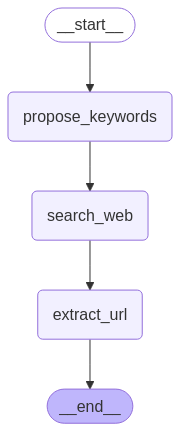

In [71]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [72]:
result = graph.invoke({"city": "resende", "state": "RJ"})



################################################################################
>>>propose_keywords
{'city': 'resende', 'state': 'RJ'}


################################################################################
>>>search_web
{'keywords': ['portal transparência resende RJ']}


################################################################################
>>>extract_url
{'results': ['[{"title": "Portal da Transpar\\u00eancia", "link": "https://resende.rj.gov.br/blogtransparencia/", "snippet": "Se n\\u00e3o for direcionado automaticamente, clique aqui"}, {"title": "Home - Prefeitura de Resende", "link": "https://resende.rj.gov.br/", "snippet": "Prefeitura Municipal de <strong>Resende</strong>, situada no interior do estado do Rio de Janeiro, com sua sede no bairro Jardim Jalisco Carta de Servi\\u00e7os Arquivo Hist\\u00f3rico Nota Fiscal Eletr\\u00f4nica ISS Cadastro Imobili\\u00e1rio Balc\\u00e3o de Empregos Capina e Varri\\u00e7\\u00e3o Ouvidoria Legisla\\u00e7\\u00e3o Tribu

In [73]:
result

{'city': 'resende',
 'state': 'RJ',
 'keywords': ['portal transparência resende RJ'],
 'results': ['[{"title": "Portal da Transpar\\u00eancia", "link": "https://resende.rj.gov.br/blogtransparencia/", "snippet": "Se n\\u00e3o for direcionado automaticamente, clique aqui"}, {"title": "Home - Prefeitura de Resende", "link": "https://resende.rj.gov.br/", "snippet": "Prefeitura Municipal de <strong>Resende</strong>, situada no interior do estado do Rio de Janeiro, com sua sede no bairro Jardim Jalisco Carta de Servi\\u00e7os Arquivo Hist\\u00f3rico Nota Fiscal Eletr\\u00f4nica ISS Cadastro Imobili\\u00e1rio Balc\\u00e3o de Empregos Capina e Varri\\u00e7\\u00e3o Ouvidoria Legisla\\u00e7\\u00e3o Tribut\\u00e1ria Conselhos Municipais ISS e Nota fiscal eletr\\u00f4nica ISS aut\\u00f4nomo Livro Eletr\\u00f4nico Boletim Oficial Unidades de Sa\\u00fade Acesso \\u00e0 Informa\\u00e7\\u00e3o Cart\\u00f3rios IPTU Autocota\\u00e7\\u00e3o para Fornecedores Unidades de Ensino Coleta de Lixo Transporte P

```mermaid
flowchart TD
    A("Inicio")
    B("Preparar query para tavily")
    C("Chamar tavily")

    A --> B

```

```mermaid
graph TB
    A -->|"Description2:A how to B"| B --> C
    A ---|"Description1:Properties of A"|A
    B --> D
    D -.-> F
    F ---|"Description1:Properties of F"|F
    C -->|"Description2:C how to F"| F
    F --> H & G & K
    H --> M
    G & K -.-> M
    linkStyle 2,5 stroke:#fff,stroke-width:0px;
```

In [ ]:
# 3. Executar o grafo
if __name__ == "__main__":
    city  = input("Digite o nome da cidade: ")
    state = input("Digite o estado (sigla): ")
    result = graph.run({"city": city, "state": state})
    print("URL do portal transparência:", result["portal_url"])


In [6]:
# Configurações do modelo LLM
llm = ChatOpenAI(
    model="gpt-4o", 
    temperature=0
)

In [7]:


# Definição do banco de dados SQLite
def setup_database():
    """Configura o banco de dados SQLite para armazenar os dados dos servidores públicos."""
    conn = sqlite3.connect('servidores_publicos.db')
    cursor = conn.cursor()
    
    # Criação da tabela para armazenar os dados
    cursor.execute('''
    CREATE TABLE IF NOT EXISTS servidores (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        cidade TEXT,
        estado TEXT,
        nome TEXT,
        cargo TEXT,
        salario REAL,
        data_coleta TEXT
    )
    ''')
    
    conn.commit()
    conn.close()
    return True

In [8]:
# Definição do estado do agente
class AgentState(TypedDict):
    cidade: str
    estado: str
    portal_url: Optional[str]
    subdominio_transparencia: Optional[str]
    endpoints_encontrados: List[Dict[str, Any]]
    endpoint_final: Optional[str]
    dados_coletados: List[Dict[str, Any]]
    messages: List[Any]
    error: Optional[str]
    completed: bool

In [11]:
cidade = "Resende"
estado = "RJ"

query = f"portal transparência prefeitura {cidade} {estado} oficial"



In [27]:
import json

tool = BraveSearch.from_api_key(api_key=os.environ["BRAVESEARCH_API_KEY"], search_kwargs={"count": 5})

results = json.loads(tool.run(query))
results

[{'title': 'Portal da Transparência',
  'link': 'https://resende.rj.gov.br/blogtransparencia/',
  'snippet': 'Se não for direcionado automaticamente, clique aqui'},
 {'title': 'Portal da Transparência - Prefeitura de Resende',
  'link': 'https://resende.rj.gov.br/blogtransparencia/page/index.asp',
  'snippet': '<strong>Prefeitura</strong> Municipal de <strong>Resende</strong>, situada no interior do estado do Rio de Janeiro, com sua sede no bairro Jardim Jalisco.'},
 {'title': 'Home - Prefeitura de Resende',
  'link': 'https://resende.rj.gov.br/',
  'snippet': 'Carta de Serviços Arquivo Histórico ... Hemonúcleo Portal da Transparência · PREFEITURA MUNICIPAL DE RESENDE · <strong>Rua Augusto Xavier de Lima, 251, bairro Jardim Jalisco, Resende/RJ, CEP: 27510-090</strong> ·... Carta de Serviços Arquivo Histórico Nota Fiscal Eletrônica ISS Cadastro Imobiliário Balcão de Empregos Capina e Varrição Ouvidoria Legislação Tributária Conselhos Municipais ISS e Nota fiscal eletrônica ISS autônomo 

In [24]:
async def extrair_sitemap(url: str) -> List[str]:
    """
    Extrai o sitemap de um site ou tenta encontrar páginas relacionadas a transparência.
    """
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url
    
    sitemap_urls = []
    parsed_url = urlparse(url)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        
        # Tenta primeiro o sitemap padrão
        try:
            await page.goto(f"{base_url}/sitemap.xml", timeout=10000)
            content = await page.content()
            if "xml" in content and "urlset" in content:
                sitemap_text = await page.inner_text("body")
                # Extrair URLs do sitemap
                import re
                urls = re.findall(r'<loc>(.*?)</loc>', sitemap_text)
                sitemap_urls.extend(urls)
        except Exception as e:
            print(f"Erro ao acessar sitemap.xml: {e}")
        
        # Se não encontrou sitemap, procura por páginas de transparência
        if not sitemap_urls:
            try:
                await page.goto(url, timeout=10000)
                
                # Busca por links relacionados à transparência
                transparency_links = await page.evaluate("""
                    () => {
                        const links = Array.from(document.querySelectorAll('a'));
                        return links
                            .filter(link => {
                                const text = link.innerText.toLowerCase();
                                const href = link.href;
                                return (
                                    text.includes('transparência') || 
                                    text.includes('transparencia') ||
                                    text.includes('servidor') || 
                                    text.includes('folha') ||
                                    text.includes('pagamento') ||
                                    text.includes('remuneração') ||
                                    text.includes('remuneracao') ||
                                    href.includes('transparencia') ||
                                    href.includes('transparência') ||
                                    href.includes('servidor') ||
                                    href.includes('folha') ||
                                    href.includes('pagamento')
                                );
                            })
                            .map(link => ({
                                text: link.innerText.trim(),
                                url: link.href
                            }));
                    }
                """)
                
                for link in transparency_links:
                    if link["url"] and link["url"] not in sitemap_urls:
                        sitemap_urls.append(link["url"])
            except Exception as e:
                print(f"Erro ao buscar links de transparência: {e}")
                
        await browser.close()
    
    return sitemap_urls

In [26]:
await extrair_sitemap("https://resende.rj.gov.br/blogtransparencia/page/index.asp")

Erro ao acessar sitemap.xml: Page.goto: Timeout 10000ms exceeded.
Call log:
navigating to "https://resende.rj.gov.br/sitemap.xml", waiting until "load"



['https://resende.rj.gov.br/blogtransparencia/page/perguntas-frequentes.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/index.asp#',
 'https://resende.rj.gov.br/blogtransparencia/page/index.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/busca.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/oquee.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/acessibilidade.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/defesa-civil.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/estatisticas-de-pedidos-de-informacao.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/links_uteis.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/responsabilidade_fiscal.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/planos-municipais.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/licitacoes-resenprevi.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/sic.asp',
 'https://resende.rj.gov.br/blogtransparencia/page/conselhos-munici

In [14]:

tavily_search = TavilySearch(k=5)

results = tavily_search.invoke(query)
results

{'query': 'portal transparência prefeitura Resende RJ oficial',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Portal Oficial da Transparência',
   'url': 'https://rj.portaldatransparencia.com.br/prefeitura/resende/?pagina=informacoes',
   'content': 'Portal Oficial da Transparência. Prefeitura Municipal de Resende-RJ. Prefeitura Municipal de Resende-RJ. Diário Oficial Eletrônico ... instrumentos de transparência da gestão fiscal e outros atos oficiais que se sujeitam ao princípio constitucional da publicidade. Tem como finalidade facilitar o acesso gratuito à informação de domínio',
   'score': 0.90330297,
   'raw_content': None},
  {'title': 'Portal da Transparência - Prefeitura de Resende - Resende, Rio de Janeiro',
   'url': 'https://resende.rj.gov.br/blogtransparencia/page/index.asp',
   'content': 'SIC Conselhos Municipais Legislação de Transparência Concessões Relatórios Certidão TCE/RJ Orgãos da Prefeitura Balanços Contábeis Consolidados R

In [ ]:






# Funções de ferramentas de busca
def buscar_portal_transparencia(cidade: str, estado: str) -> List[Dict[str, Any]]:
    """
    Busca o portal de transparência de uma cidade usando ferramentas de busca.
    Tenta primeiro o Tavily, depois o DuckDuckGo, e finalmente o Brave Search.
    """
    query = f"portal transparência prefeitura {cidade} {estado} oficial"
    
    # Tentativa 1: Tavily
    try:
        tavily_search = TavilySearchResults(k=5)
        results = tavily_search.invoke(query)
        if results:
            return results
    except Exception as e:
        print(f"Erro na busca Tavily: {e}")
    
    # Tentativa 2: DuckDuckGo
    try:
        ddg_search = DuckDuckGoSearchAPIWrapper()
        results = ddg_search.results(query, max_results=5)
        if results:
            return [{"url": r["link"], "content": r["snippet"], "title": r["title"]} for r in results]
    except Exception as e:
        print(f"Erro na busca DuckDuckGo: {e}")
    
    # Tentativa 3: Brave Search
    try:
        brave_search = BraveSearch()
        results = brave_search.results(query, count=5)
        if results:
            return [{"url": r["link"], "content": r["text"], "title": r["title"]} for r in results]
    except Exception as e:
        print(f"Erro na busca Brave: {e}")
    
    # Se todas as tentativas falharem
    return []

async def extrair_sitemap(url: str) -> List[str]:
    """
    Extrai o sitemap de um site ou tenta encontrar páginas relacionadas a transparência.
    """
    if not url.startswith(('http://', 'https://')):
        url = 'https://' + url
    
    sitemap_urls = []
    parsed_url = urlparse(url)
    base_url = f"{parsed_url.scheme}://{parsed_url.netloc}"
    
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        page = await browser.new_page()
        
        # Tenta primeiro o sitemap padrão
        try:
            await page.goto(f"{base_url}/sitemap.xml", timeout=10000)
            content = await page.content()
            if "xml" in content and "urlset" in content:
                sitemap_text = await page.inner_text("body")
                # Extrair URLs do sitemap
                import re
                urls = re.findall(r'<loc>(.*?)</loc>', sitemap_text)
                sitemap_urls.extend(urls)
        except Exception as e:
            print(f"Erro ao acessar sitemap.xml: {e}")
        
        # Se não encontrou sitemap, procura por páginas de transparência
        if not sitemap_urls:
            try:
                await page.goto(url, timeout=10000)
                
                # Busca por links relacionados à transparência
                transparency_links = await page.evaluate("""
                    () => {
                        const links = Array.from(document.querySelectorAll('a'));
                        return links
                            .filter(link => {
                                const text = link.innerText.toLowerCase();
                                const href = link.href;
                                return (
                                    text.includes('transparência') || 
                                    text.includes('transparencia') ||
                                    text.includes('servidor') || 
                                    text.includes('folha') ||
                                    text.includes('pagamento') ||
                                    text.includes('remuneração') ||
                                    text.includes('remuneracao') ||
                                    href.includes('transparencia') ||
                                    href.includes('transparência') ||
                                    href.includes('servidor') ||
                                    href.includes('folha') ||
                                    href.includes('pagamento')
                                );
                            })
                            .map(link => ({
                                text: link.innerText.trim(),
                                url: link.href
                            }));
                    }
                """)
                
                for link in transparency_links:
                    if link["url"] and link["url"] not in sitemap_urls:
                        sitemap_urls.append(link["url"])
            except Exception as e:
                print(f"Erro ao buscar links de transparência: {e}")
                
        await browser.close()
    
    return sitemap_urls

async def encontrar_pagina_servidores(urls: List[str]) -> Tuple[str, str]:
    """
    Analisa uma lista de URLs para encontrar a página que contém dados de servidores públicos.
    Retorna a URL da página e o texto de descrição.
    """
    relevant_page = ""
    page_description = ""
    
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=True)
        
        for url in urls:
            try:
                page = await browser.new_page()
                await page.goto(url, timeout=15000)
                
                # Verifica se a página contém palavras-chave relacionadas a servidores públicos
                page_text = await page.evaluate("""
                    () => {
                        return document.body.innerText;
                    }
                """)
                
                # Verifica se o título ou conteúdo da página está relacionado a servidores
                keywords = [
                    "servidor", "servidores", "folha de pagamento", "remuneração", 
                    "salário", "salários", "funcionários", "funcionário", 
                    "pessoal", "quadro de pessoal", "contracheque"
                ]
                
                if any(keyword in page_text.lower() for keyword in keywords):
                    # Verifica se há tabelas ou elementos de formulário que possam conter dados
                    has_tables = await page.evaluate("""
                        () => {
                            return document.querySelectorAll('table').length > 0 || 
                                   document.querySelectorAll('form').length > 0 ||
                                   document.querySelectorAll('input').length > 0 ||
                                   document.querySelectorAll('select').length > 0 ||
                                   document.querySelectorAll('div[data-role="grid"]').length > 0 ||
                                   document.querySelectorAll('div.grid').length > 0;
                        }
                    """)
                    
                    if has_tables:
                        relevant_page = url
                        page_title = await page.title()
                        page_description = f"Página encontrada: {page_title} - Contém palavras-chave relacionadas a servidores e elementos de tabela/formulário."
                        break
            
            except Exception as e:
                print(f"Erro ao analisar a URL {url}: {e}")
            finally:
                await page.close()
        
        await browser.close()
    
    return relevant_page, page_description

async def capturar_requisicoes_api(url: str) -> List[Dict[str, Any]]:
    """
    Captura as requisições API feitas por uma página web.
    Analisa os dados retornados para encontrar endpoints relacionados a servidores públicos.
    """
    api_requests = []
    
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False)  # Headless=False para garantir carregamento completo da página
        
        context = await browser.new_context()
        
        # Configura a interceptação de requisições
        page = await context.new_page()
        
        # Lista para armazenar as requisições
        request_logs = []
        
        # Função para interceptar requisições
        async def handle_request(request):
            if request.resource_type in ["xhr", "fetch"] and request.method != "OPTIONS":
                try:
                    # Armazena informações da requisição
                    req_info = {
                        "url": request.url,
                        "method": request.method,
                        "headers": request.headers,
                        "resource_type": request.resource_type,
                        "post_data": request.post_data,
                        "response": None
                    }
                    
                    # Espera a resposta
                    response = await request.response()
                    if response:
                        req_info["response"] = {
                            "status": response.status,
                            "headers": response.headers,
                        }
                        
                        # Tenta capturar o corpo da resposta
                        try:
                            content_type = response.headers.get("content-type", "")
                            if "json" in content_type or "application/json" in content_type:
                                body_text = await response.text()
                                try:
                                    req_info["response"]["body"] = json.loads(body_text)
                                except:
                                    req_info["response"]["body"] = body_text[:1000]  # Limita o tamanho para evitar memória excessiva
                            elif "text" in content_type:
                                body_text = await response.text()
                                req_info["response"]["body"] = body_text[:1000]
                        except:
                            req_info["response"]["body"] = "Erro ao capturar corpo da resposta"
                    
                    request_logs.append(req_info)
                except Exception as e:
                    print(f"Erro ao processar requisição: {e}")
        
        # Configura o listener de requisições
        await page.route("**/*", handle_request)
        
        # Navega para a URL e espera o carregamento completo
        await page.goto(url, wait_until="networkidle")
        
        # Espera alguns segundos para garantir que scripts AJAX sejam executados
        await page.wait_for_timeout(5000)
        
        # Tenta interagir com a página para acionar mais requisições
        try:
            # Procura por botões de pesquisa ou filtros
            buttons = await page.query_selector_all("button, input[type='submit'], a.btn")
            for button in buttons[:3]:  # Limita a 3 botões para não sobrecarregar
                try:
                    await button.click()
                    await page.wait_for_timeout(2000)  # Espera um pouco após cada clique
                except:
                    pass
            
            # Procura por campos de seleção (dropdowns)
            selects = await page.query_selector_all("select")
            for select in selects[:2]:  # Limita a 2 selects
                try:
                    await select.click()
                    options = await select.query_selector_all("option")
                    if len(options) > 1:  # Se houver opções
                        await options[1].click()  # Clica na segunda opção
                    await page.wait_for_timeout(2000)
                except:
                    pass
        except Exception as e:
            print(f"Erro ao interagir com a página: {e}")
        
        # Espera final para capturar todas as requisições
        await page.wait_for_timeout(3000)
        
        # Processa os logs para identificar APIs relacionadas a servidores
        for req in request_logs:
            url_lower = req["url"].lower()
            
            # Verifica se a URL ou o corpo da resposta contém palavras-chave relacionadas a servidores
            api_related = any(keyword in url_lower for keyword in [
                "servidor", "servidores", "funcionario", "folha", "pagamento", 
                "remuneracao", "salario", "pessoal", "contracheque"
            ])
            
            # Verifica também o corpo da resposta
            if not api_related and req.get("response") and req["response"].get("body"):
                response_content = str(req["response"]["body"]).lower()
                api_related = any(keyword in response_content for keyword in [
                    "servidor", "nome", "cargo", "salario", "remuneracao", "lotacao",
                    "matricula", "folha", "pagamento"
                ])
            
            if api_related:
                api_requests.append(req)
        
        await browser.close()
    
    return api_requests

async def extrair_dados_api(endpoint: Dict[str, Any], cidade: str, estado: str) -> List[Dict[str, Any]]:
    """
    Extrai dados de um endpoint de API, possivelmente fazendo várias requisições
    para lidar com paginação.
    """
    url = endpoint["url"]
    method = endpoint.get("method", "GET")
    headers = endpoint.get("headers", {})
    post_data = endpoint.get("post_data")
    
    all_data = []
    page = 1
    max_pages = 100  # Limite de segurança
    
    # Analisar a URL para entender a estrutura e a paginação
    url_params = {}
    if "?" in url:
        base_url, query_string = url.split("?", 1)
        for param in query_string.split("&"):
            if "=" in param:
                key, value = param.split("=", 1)
                url_params[key] = value
    else:
        base_url = url
    
    # Identificar possíveis parâmetros de paginação
    page_param = None
    for param in url_params:
        if param.lower() in ["page", "pagina", "p", "pag", "offset", "start"]:
            page_param = param
            break
    
    while page <= max_pages:
        try:
            current_url = url
            current_post_data = post_data
            
            # Modificar URL ou dados POST para paginação
            if page_param and page > 1:
                if "?" in current_url:
                    # Substitui o parâmetro de página na URL
                    parts = current_url.split("?")
                    base = parts[0]
                    params = parts[1].split("&")
                    
                    new_params = []
                    for param in params:
                        if param.startswith(f"{page_param}="):
                            new_params.append(f"{page_param}={page}")
                        else:
                            new_params.append(param)
                    
                    current_url = f"{base}?{'&'.join(new_params)}"
                else:
                    # Adiciona o parâmetro de página se não existir
                    current_url = f"{current_url}?{page_param}={page}"
            
            # Se tiver dados POST e for JSON, tenta ajustar a paginação
            if current_post_data and page > 1:
                try:
                    post_json = json.loads(current_post_data)
                    # Procura campos comuns de paginação
                    for field in ["page", "pagina", "pageNumber", "numeroPagina", "offset"]:
                        if field in post_json:
                            post_json[field] = page
                    # Atualiza os dados POST
                    current_post_data = json.dumps(post_json)
                except:
                    pass
            
            # Faz a requisição
            if method.upper() == "GET":
                response = requests.get(current_url, headers=headers, timeout=30)
            else:  # POST, PUT, etc.
                response = requests.request(
                    method=method.upper(),
                    url=current_url,
                    headers=headers,
                    data=current_post_data,
                    timeout=30
                )
            
            # Verifica se a resposta é válida
            if response.status_code != 200:
                print(f"Erro na requisição à página {page}: Status {response.status_code}")
                break
            
            # Processa os dados da resposta
            try:
                data = response.json()
                
                # Identifica se é uma lista ou está dentro de alguma propriedade
                items = []
                if isinstance(data, list):
                    items = data
                elif isinstance(data, dict):
                    # Procura por campos comuns que contêm listas de dados
                    for field in ["data", "dados", "items", "results", "registros", "content", "servidores", "funcionarios"]:
                        if field in data and isinstance(data[field], list):
                            items = data[field]
                            break
                
                # Se encontrou itens, adiciona à lista completa
                if items:
                    all_data.extend(items)
                    print(f"Página {page}: {len(items)} registros encontrados")
                else:
                    print(f"Nenhum item encontrado na página {page}")
                    break
                
                # Verifica se há mais páginas
                has_more = False
                if isinstance(data, dict):
                    pagination_info = {
                        "has_next": data.get("hasNext", data.get("has_next", data.get("hasMorePages", False))),
                        "total_pages": data.get("totalPages", data.get("total_pages", data.get("paginas", 0))),
                        "last_page": data.get("lastPage", data.get("last_page", data.get("ultima_pagina", 0)))
                    }
                    
                    if pagination_info["has_next"] is True:
                        has_more = True
                    elif pagination_info["total_pages"] and page < pagination_info["total_pages"]:
                        has_more = True
                    elif pagination_info["last_page"] and page < pagination_info["last_page"]:
                        has_more = True
                    elif len(items) == 0:
                        has_more = False
                    else:
                        # Se não há informação explícita, assumimos que há mais páginas se encontramos dados
                        has_more = len(items) > 0
                else:
                    # Se a resposta é uma lista direta, continuamos se encontramos dados
                    has_more = len(items) > 0
                
                if not has_more:
                    break
                
                # Avança para a próxima página
                page += 1
                time.sleep(1)  # Pausa para não sobrecarregar o servidor
                
            except Exception as e:
                print(f"Erro ao processar dados da página {page}: {e}")
                break
                
        except Exception as e:
            print(f"Erro ao fazer requisição para a página {page}: {e}")
            break
    
    return all_data

def salvar_dados_sqlite(dados: List[Dict[str, Any]], cidade: str, estado: str) -> bool:
    """
    Salva os dados coletados no banco de dados SQLite.
    """
    if not dados:
        return False
    
    try:
        conn = sqlite3.connect('servidores_publicos.db')
        cursor = conn.cursor()
        
        data_coleta = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        count = 0
        
        for item in dados:
            # Tenta encontrar campos relacionados a nome, cargo e salário
            nome = None
            cargo = None
            salario = None
            
            # Mapeamentos possíveis de campos para nome
            for field in ["nome", "nome_servidor", "servidor", "funcionario", "nome_funcionario", "name"]:
                if field in item:
                    nome = item[field]
                    break
            
            # Mapeamentos possíveis de campos para cargo
            for field in ["cargo", "funcao", "carreira", "position", "occupation", "job_title", "cargo_funcao"]:
                if field in item:
                    cargo = item[field]
                    break
            
            # Mapeamentos possíveis de campos para salário
            for field in ["salario", "remuneracao", "valor", "vencimento", "salary", "remuneracao_basica", "rendimento", "total_rendimentos"]:
                if field in item:
                    try:
                        # Tenta converter para float, removendo não-numéricos
                        value = item[field]
                        if isinstance(value, str):
                            # Remove R$, pontos e substitui vírgula por ponto
                            value = value.replace("R$", "").replace(".", "").replace(",", ".").strip()
                        salario = float(value)
                    except:
                        # Se falhar, deixa como None
                        pass
                    break
            
            # Se encontrou pelo menos nome e cargo, salva no banco
            if nome and cargo:
                cursor.execute(
                    """
                    INSERT INTO servidores (cidade, estado, nome, cargo, salario, data_coleta)
                    VALUES (?, ?, ?, ?, ?, ?)
                    """,
                    (cidade, estado, nome, cargo, salario, data_coleta)
                )
                count += 1
        
        conn.commit()
        conn.close()
        
        print(f"Dados salvos com sucesso! {count} registros inseridos.")
        return True
    except Exception as e:
        print(f"Erro ao salvar dados no SQLite: {e}")
        return False

# Função para analisar e identificar o melhor endpoint para dados de servidores
def analisar_endpoints(api_requests: List[Dict[str, Any]]) -> Dict[str, Any]:
    """
    Analisa os endpoints capturados para identificar o melhor para extração de dados.
    """
    # Pontuação para cada endpoint baseada em heurísticas
    endpoint_scores = []
    
    for req in api_requests:
        score = 0
        url = req["url"].lower()
        
        # Analisa a URL
        if any(k in url for k in ["servidor", "folha", "pagamento", "remuneracao", "salario"]):
            score += 10
        
        # Analisa os cabeçalhos e métodos
        if req["method"] == "GET":
            score += 5  # GET geralmente é mais fácil de trabalhar
        
        # Analisa o corpo da resposta
        response = req.get("response", {})
        body = response.get("body", {})
        
        if body:
            # Converte para string se não for
            if not isinstance(body, str):
                body_str = str(body).lower()
            else:
                body_str = body.lower()
            
            # Verifica palavras-chave no corpo
            for keyword in ["nome", "servidor", "cargo", "salario", "remuneracao", "vencimento"]:
                if keyword in body_str:
                    score += 3
            
            # Verifica se parece uma lista de servidores
            if isinstance(body, list) or (isinstance(body, dict) and any(
                isinstance(body.get(k), list) for k in ["data", "dados", "items", "results"]
            )):
                score += 15
            
            # Verifica se há indícios de paginação
            if any(k in body_str for k in ["page", "pagina", "pagination", "paginacao", "total_pages"]):
                score += 10
        
        endpoint_scores.append({"endpoint": req, "score": score})
    
    # Ordena por pontuação
    endpoint_scores.sort(key=lambda x: x["score"], reverse=True)
    
    # Retorna o endpoint com maior pontuação, se houver
    if endpoint_scores:
        return endpoint_scores[0]["endpoint"]
    
    return None

# Funções de nós do grafo LangGraph

# Nó de inicialização
def inicializar(state: AgentState) -> AgentState:
    """Inicializa o estado do agente e o banco de dados."""
    setup_database()
    return state

# Nó para buscar o portal de transparência
def buscar_portal(state: AgentState) -> AgentState:
    """Busca o portal de transparência da cidade especificada."""
    try:
        cidade = state["cidade"]
        estado = state["estado"]
        
        resultados = buscar_portal_transparencia(cidade, estado)
        
        if not resultados:
            return {**state, "error": f"Não foi possível encontrar o portal de transparência para {cidade}/{estado}"}
        
        # Analisa os resultados para encontrar o site oficial
        analysis_prompt = f"""
        Analise os resultados de busca abaixo e identifique a URL do portal de transparência oficial da Prefeitura de {cidade}, {estado}.
        Escolha apenas um resultado que pareça ser o portal oficial da prefeitura.
        
        Resultados:
        {resultados}
        
        Retorne apenas a URL completa do portal, sem comentários adicionais.
        """
        
        messages = [HumanMessage(content=analysis_prompt)]
        portal_url = llm.invoke(messages).content.strip()
        
        # Verifica e corrige a URL se necessário
        if not portal_url.startswith(('http://', 'https://')):
            portal_url = 'https://' + portal_url
        
        # Adiciona mensagens ao histórico
        messages = add_messages(
            state["messages"],
            HumanMessage(content=f"Buscando portal de transparência de {cidade}/{estado}..."),
            AIMessage(content=f"Portal de transparência encontrado: {portal_url}")
        )
        
        return {**state, "portal_url": portal_url, "messages": messages}
    
    except Exception as e:
        return {**state, "error": f"Erro ao buscar portal: {str(e)}"}

# Nó para encontrar o subdomínio de transparência
async def encontrar_subdominio(state: AgentState) -> AgentState:
    """Encontra o subdomínio ou página com dados de servidores no portal."""
    try:
        portal_url = state["portal_url"]
        
        # Extrai o sitemap ou links relacionados
        urls = await extrair_sitemap(portal_url)
        
        if not urls:
            return {**state, "error": "Não foi possível extrair o sitemap ou encontrar links de transparência"}
        
        # Encontra a página com dados de servidores
        pagina_servidores, descricao = await encontrar_pagina_servidores(urls)
        
        if not pagina_servidores:
            # Se não encontrou nas URLs do sitemap, tenta diretamente no portal
            pagina_servidores, descricao = await encontrar_pagina_servidores([portal_url])
        
        if not pagina_servidores:
            return {**state, "error": "Não foi possível encontrar a página com dados de servidores"}
        
        # Adiciona mensagens ao histórico
        messages = add_messages(
            state["messages"],
            HumanMessage(content="Buscando página com dados de servidores..."),
            AIMessage(content=f"Página encontrada: {pagina_servidores}\n{descricao}")
        )
        
        return {**state, "subdominio_transparencia": pagina_servidores, "messages": messages}
    
    except Exception as e:
        return {**state, "error": f"Erro ao encontrar subdomínio: {str(e)}"}

# Nó para capturar requisições e endpoints
async def capturar_endpoints(state: AgentState) -> AgentState:
    """Captura e analisa as requisições feitas pela página de transparência."""
    try:
        subdominio = state["subdominio_transparencia"]
        
        # Captura as requisições
        api_requests = await capturar_requisicoes_api(subdominio)
        
        if not api_requests:
            return {**state, "error": "Não foi possível capturar requisições API na página"}
        
        # Analisa os endpoints para encontrar o melhor
        melhor_endpoint = analisar_endpoints(api_requests)
        
        if not melhor_endpoint:
            return {**state, "error": "Não foi possível identificar um endpoint adequado para dados de servidores"}
        
        # Adiciona mensagens ao histórico
        endpoint_url = melhor_endpoint["url"]
        messages = add_messages(
            state["messages"],
            HumanMessage



In [3]:
# !pip install langgraph langchain langchain-community langchain-openai

Gere um código com langgraph de um agente que recebe uma url e popule um dicionário com todos os links dessa url. Os valores do dicionário devem ser False.
Adicione a própria url da página no dicionário com valor igual a true.

Então, assim que todos os links da página estiverem sido coletados.

Entre no primeiro link do dicionário com valor igual a false. Colete todos os links e os popule no dicionário. Mude o valor desse link de false para true.


Entre no próximo link do dicionário com valor igual a false. Colete todos os links e os popule no dicionário. Mude o valor desse link de false para true.

Repita isso até que todos os links no dicionário tenham valor true

In [2]:
1 + 2 + 3

6

In [3]:
asd = 1

In [4]:
import kacilds




ModuleNotFoundError: No module named 'kacilds'

In [19]:
import requests
from time import sleep
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import re
from typing import Dict, List, Tuple, Any, TypedDict, Annotated
from langgraph.graph import StateGraph, END
from langchain_core.tools import tool, ToolException

# Definição do estado do grafo como TypedDict para melhor tipagem
class CrawlerState(TypedDict):
    """Estado do crawler."""
    links_dict: Dict[str, bool]  # dicionário de links: {url: visitado}
    current_url: str             # URL atual
    error: str                   # mensagem de erro se houver
    done: bool                   # flag para indicar conclusão

# Ferramentas do agente
@tool
def fetch_links(url: str) -> Dict[str, Any]:
    """Busca todos os links de uma página web."""
    try:
        # Fazer requisição HTTP
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parsear o HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extrair links
        raw_links = []
        for a_tag in soup.find_all('a', href=True):
            href = a_tag['href']
            # Converter links relativos para absolutos
            full_url = urljoin(url, href)
            # Filtrar apenas URLs HTTP/HTTPS
            if full_url.startswith(('http://', 'https://')):
                # Limpar fragmentos e parâmetros de consulta
                parsed = urlparse(full_url)
                clean_url = f"{parsed.scheme}://{parsed.netloc}{parsed.path}"
                raw_links.append(clean_url)
        
        # Remover duplicatas
        links = list(set(raw_links))

        return {"links": links, "success": True}
    
    except Exception as e:
        raise ToolException(f"Erro ao buscar links de {url}: {str(e)}")

# Nós do grafo
def initialize(state: CrawlerState) -> CrawlerState:
    """Inicializa o crawler com a URL semente."""
    
    if not state["current_url"]:
        raise ValueError("URL inicial não fornecida")
    
    # Inicializar o dicionário de links
    state["links_dict"] = {state["current_url"]: False}
    state["done"] = False
    state["error"] = ""
    return state

def process_url(state: CrawlerState) -> CrawlerState:
    """Processa a URL atual, extraindo links e atualizando o dicionário."""
    
    current_url = state["current_url"]
    
    # Verificar se a URL já foi visitada
    if state["links_dict"].get(current_url, False):
        return state
    
    try:
        # Buscar links da URL atual
        result = fetch_links(current_url)
        
        if result.get("success", False):
            # Adicionar novos links ao dicionário
            for link in result.get("links", []):
                if link not in state["links_dict"]:
                    state["links_dict"][link] = False
            
            # Marcar a URL atual como visitada
            state["links_dict"][current_url] = True
        
    except ToolException as e:
        state["error"] = str(e)
        # Mesmo com erro, marcamos como visitado para não tentar novamente
        state["links_dict"][current_url] = True
    
    return state

def select_next_url(state: CrawlerState) -> CrawlerState:
    """Seleciona a próxima URL não visitada para processar."""
    
    unvisited_urls = [url for url, visited in state["links_dict"].items() if not visited]
    
    if unvisited_urls:
        state["current_url"] = unvisited_urls[0]  # Pega o primeiro link não visitado
        print(state["current_url"])
    else:
        state["done"] = True  # Todos os links foram visitados
    
    return state

# Função para verificar se o crawler terminou
def check_completion(state: CrawlerState) -> str:
    """Verifica se o crawler terminou."""
    if state["done"]:
        return "done"
    return "continue"

# Construção do grafo
def build_crawler_graph() -> StateGraph:
    """Constrói o grafo do crawler."""

    builder = StateGraph(CrawlerState)

    builder.add_node("initialize", initialize)
    builder.add_node("process_url", process_url)
    builder.add_node("select_next_url", select_next_url)

    builder.add_edge("initialize", "process_url")
    builder.add_edge("process_url", "select_next_url")

    builder.add_conditional_edges(
        "select_next_url",
        check_completion,
        {
            "continue": "process_url",
            "done": END
        }
    )

    builder.set_entry_point("initialize")

    graph = builder.compile()
    
    return graph

# Ponto de execução
def run_crawler(seed_url: str, max_links: int = 100) -> Dict[str, bool]:
    """Executa o crawler começando na URL semente."""

    graph = build_crawler_graph()
    
    initial_state: CrawlerState = {
        "current_url": seed_url,
        "links_dict": {},
        "error": "",
        "done": False
    }

    final_state = graph.invoke(initial_state)

    result_dict = dict(list(final_state["links_dict"].items())[:max_links])
    
    return result_dict


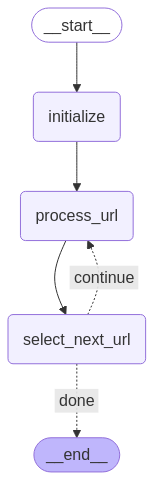

In [20]:
graph = build_crawler_graph()

graph

In [21]:
initial_state: CrawlerState = {
    "current_url": "https://resende.rj.gov.br/blogtransparencia/page/index.asp",
    "links_dict": {},
    "error": "",
    "done": False
}

final_state = graph.invoke(initial_state, {"recursion_limit": 100})

https://resende.rj.gov.br/blogtransparencia/page/educacao.asp
https://resende.rj.gov.br/ouvidoria/principal/
https://resende.rj.gov.br/blogtransparencia/page/perguntas-frequentes.asp
https://resende.rj.gov.br/blogtransparencia/page/concessoes.asp
https://resende.rj.gov.br/servicos/unidades-de-ensino/
https://userway.org
https://resende.rj.gov.br/blogtransparencia/page/quadrodepessoasetabela.asp
https://resende.rj.gov.br/blogtransparencia/page/planos-municipais.asp
https://resende.rj.gov.br/blogtransparencia/page/estatisticas-de-pedidos-de-informacao.asp
https://resende.rj.gov.br/blogtransparencia/page/responsabilidade_fiscal.asp
https://resende.rj.gov.br/fazenda/principal/
https://www.resende.rj.gov.br/blogtransparencia/page/audiencias_publicas_metas.asp
https://resende.rj.gov.br/desenvolvimento-rural/principal/
https://resende.rj.gov.br/blogtransparencia/page/demonstrativo_obras.asp
https://resende.rj.gov.br/blogtransparencia/page/busca.asp
https://resende.rj.gov.br/superintendencia-d

GraphRecursionError: Recursion limit of 100 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:

# Exemplo de uso
if __name__ == "__main__":
    import sys
    
    if len(sys.argv) > 1:
        url = sys.argv[1]
    else:
        url = "https://example.com"
    
    print(f"Iniciando crawler com a URL: {url}")
    result = run_crawler(url)
    
    print("\nResultados:")
    visited = sum(1 for visited in result.values() if visited)
    print(f"Total de URLs encontradas: {len(result)}")
    print(f"URLs visitadas: {visited}")
    
    print("\nPrimeiras 10 URLs:")
    for i, (url, visited) in enumerate(list(result.items())[:10]):
        print(f"{i+1}. {'[Visitado]' if visited else '[Não visitado]'} {url}")

# Antiga

In [4]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse
import re
from typing import Dict, List, Tuple, Any
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolExecutor
from langchain_core.tools import tool

# Estado do grafo
class CrawlerState:
    """Estado do crawler."""
    
    def __init__(self):
        self.links_dict: Dict[str, bool] = {}  # dicionário de links: {url: visitado}
        self.current_url: str = ""              # URL atual
        self.error: str = ""                    # mensagem de erro se houver
        self.done: bool = False                 # flag para indicar conclusão

# Ferramentas do agente
@tool
def fetch_links(url: str) -> Dict[str, List[str]]:
    """Busca todos os links de uma página web."""
    try:
        # Fazer requisição HTTP
        headers = {'User-Agent': 'Mozilla/5.0'}
        response = requests.get(url, headers=headers, timeout=10)
        response.raise_for_status()
        
        # Parsear o HTML
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Extrair links
        raw_links = []
        for a_tag in soup.find_all('a', href=True):
            href = a_tag['href']
            # Converter links relativos para absolutos
            full_url = urljoin(url, href)
            # Filtrar apenas URLs HTTP/HTTPS
            if full_url.startswith(('http://', 'https://')):
                # Limpar fragmentos e parâmetros de consulta
                parsed = urlparse(full_url)
                clean_url = f"{parsed.scheme}://{parsed.netloc}{parsed.path}"
                raw_links.append(clean_url)
        
        # Remover duplicatas
        links = list(set(raw_links))
        return {"links": links, "success": True}
    
    except Exception as e:
        return {"links": [], "success": False, "error": str(e)}

# Nós do grafo
def initialize(state: CrawlerState) -> CrawlerState:
    """Inicializa o crawler com a URL semente."""
    if not state.current_url:
        raise ValueError("URL inicial não fornecida")
    
    # Inicializar o dicionário de links
    state.links_dict = {state.current_url: False}
    state.done = False
    state.error = ""
    return state

def process_url(state: CrawlerState) -> CrawlerState:
    """Processa a URL atual, extraindo links e atualizando o dicionário."""
    current_url = state.current_url
    
    # Verificar se a URL já foi visitada
    if state.links_dict.get(current_url, False):
        return state
    
    # Buscar links da URL atual
    result = fetch_links(current_url)
    
    if result.get("success", False):
        # Adicionar novos links ao dicionário
        for link in result.get("links", []):
            if link not in state.links_dict:
                state.links_dict[link] = False
        
        # Marcar a URL atual como visitada
        state.links_dict[current_url] = True
    else:
        state.error = f"Erro ao processar {current_url}: {result.get('error', 'Desconhecido')}"
        # Mesmo com erro, marcamos como visitado para não tentar novamente
        state.links_dict[current_url] = True
    
    return state

def select_next_url(state: CrawlerState) -> CrawlerState:
    """Seleciona a próxima URL não visitada para processar."""
    unvisited_urls = [url for url, visited in state.links_dict.items() if not visited]
    
    if unvisited_urls:
        state.current_url = unvisited_urls[0]  # Pega o primeiro link não visitado
    else:
        state.done = True  # Todos os links foram visitados
    
    return state

def check_completion(state: CrawlerState) -> str:
    """Verifica se o crawler terminou."""
    if state.done:
        return "done"
    return "continue"

# Construção do grafo
def build_crawler_graph() -> Tuple[StateGraph, ToolExecutor]:
    """Constrói o grafo do crawler."""
    # Iniciar o grafo com o estado do crawler
    graph = StateGraph(CrawlerState)
    
    # Adicionar nós
    graph.add_node("initialize", initialize)
    graph.add_node("process_url", process_url)
    graph.add_node("select_next_url", select_next_url)
    
    # Definir o fluxo
    graph.add_edge("initialize", "process_url")
    graph.add_edge("process_url", "select_next_url")
    graph.add_edge("select_next_url", "process_url")
    
    # Definir condição de término
    graph.add_conditional_edges(
        "select_next_url",
        check_completion,
        {
            "continue": "process_url",
            "done": END
        }
    )
    
    # Definir o nó inicial
    graph.set_entry_point("initialize")
    
    # Compilar o grafo
    executor = graph.compile()
    
    # Criar executor de ferramentas
    tools_executor = ToolExecutor([fetch_links])
    
    return executor, tools_executor

# Ponto de execução
def run_crawler(seed_url: str, max_links: int = 100) -> Dict[str, bool]:
    """Executa o crawler começando na URL semente."""
    # Construir o grafo
    executor, _ = build_crawler_graph()
    
    # Preparar o estado inicial
    initial_state = CrawlerState()
    initial_state.current_url = seed_url
    
    # Executar o grafo
    final_state = executor.invoke(initial_state)
    
    # Limitar o número de links no resultado (caso haja muitos)
    result_dict = dict(list(final_state.links_dict.items())[:max_links])
    
    return result_dict

# # Exemplo de uso
# if __name__ == "__main__":
#     import sys
    
#     if len(sys.argv) > 1:
#         url = sys.argv[1]
#     else:
#         url = "https://example.com"
    
#     print(f"Iniciando crawler com a URL: {url}")
#     result = run_crawler(url)
    
#     print("\nResultados:")
#     visited = sum(1 for visited in result.values() if visited)
#     print(f"Total de URLs encontradas: {len(result)}")
#     print(f"URLs visitadas: {visited}")
    
#     print("\nPrimeiras 10 URLs:")
#     for i, (url, visited) in enumerate(list(result.items())[:10]):
#         print(f"{i+1}. {'[Visitado]' if visited else '[Não visitado]'} {url}")

ImportError: cannot import name 'ToolExecutor' from 'langgraph.prebuilt' (/usr/local/lib/python3.12/site-packages/langgraph/prebuilt/__init__.py)